# Grid search for Delay Embedding & Ridge Regression for NVAR

It performs a grid search over delay taps k and ridge regularization values $\alpha$, then visualizes prediction accuracy via RMSE heatmaps.

Azimov Sherkhon \\
Pusan National University \\
sherxonazimov94@pusan.ac.kr \\
May 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

In [2]:
# Time settings
dt = 0.025
warmup = 5.0
traintime = 36.0
testtime = 4.0
maxtime = warmup + traintime + testtime
plottime = 4.0

# Convert to discrete steps
warmup_pts = round(warmup / dt)
traintime_pts = round(traintime / dt)
warmtrain_pts = warmup_pts + traintime_pts
testtime_pts = round(testtime / dt)
maxtime_pts = round(maxtime / dt)
plottime_pts = round(plottime / dt)

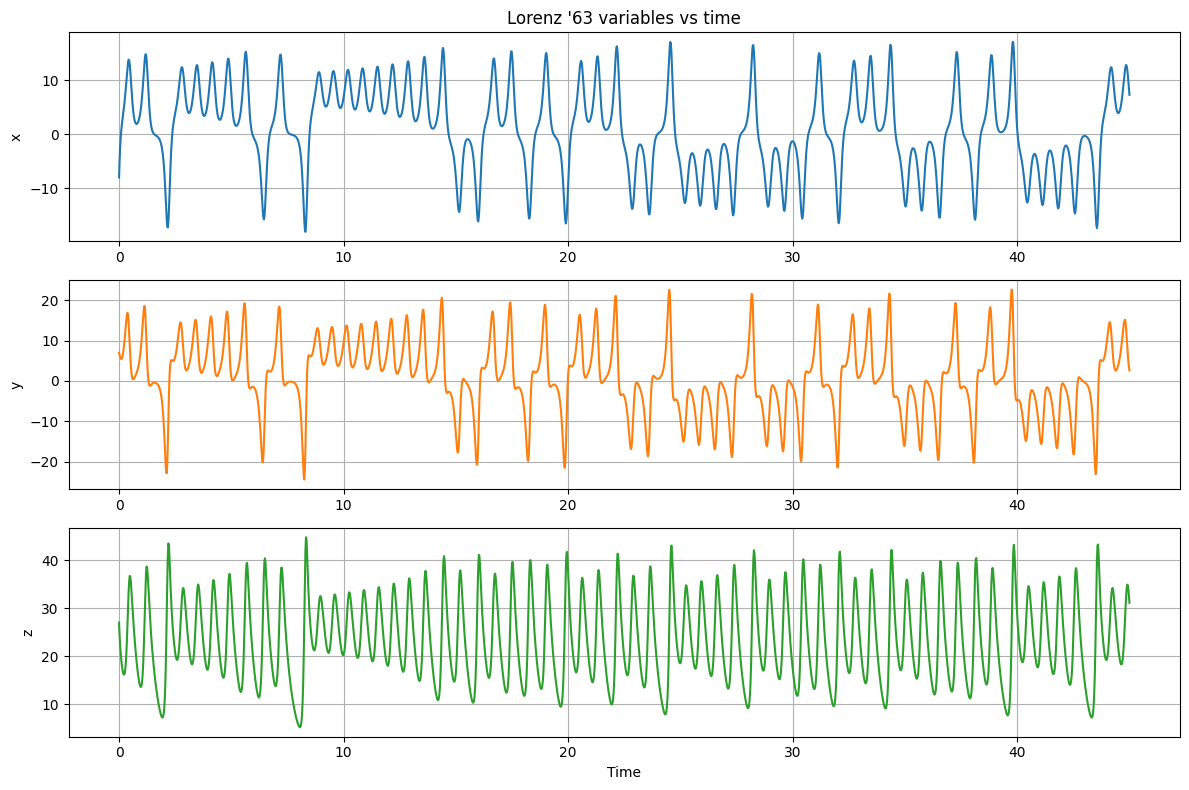

In [3]:
# ---------------------- Load Data ----------------------
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)

data_file = "0percent0025.npy"
lorenz_soln = (np.load(data_file)).T

# Plot Lorenz variables
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_soln[i], label=variables[i], color=f'C{i}')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables vs time")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [4]:
# ---------------------- Grid Search Parameters Phase 1 ----------------------
d = 3  # Dimension of the system
k_values = range(1, 4)  # Delay taps
ridge_values = np.logspace(-6, -1, 10001)  # Ridge parameters
results = []

# ---------------------- Grid Search ----------------------
for k, ridge_param in itertools.product(k_values, ridge_values):
    dlin = k * d
    dnonlin = int(dlin * (dlin + 1) / 2)
    dtot = 1 + dlin + dnonlin

    x = np.zeros((dlin, maxtime_pts))
    for delay in range(k):
        for j in range(delay, maxtime_pts):
            x[d * delay:d * (delay + 1), j] = lorenz_soln[:, j - delay]

    # Training features
    out_train = np.ones((dtot, traintime_pts))
    out_train[1:dlin + 1, :] = x[:, warmup_pts - 1:warmtrain_pts - 1]

    cnt = 0
    for row in range(dlin):
        for col in range(row, dlin):
            out_train[dlin + 1 + cnt] = (
                x[row, warmup_pts - 1:warmtrain_pts - 1] *
                x[col, warmup_pts - 1:warmtrain_pts - 1]
            )
            cnt += 1

    # Ridge regression
    delta_x = x[0:d, warmup_pts:warmtrain_pts] - x[0:d, warmup_pts - 1:warmtrain_pts - 1]
    W_out = delta_x @ out_train.T @ np.linalg.pinv(out_train @ out_train.T + ridge_param * np.identity(dtot))

    # Prediction
    out_test = np.zeros(dtot)
    x_test = np.zeros((dlin, testtime_pts))
    x_test[:, 0] = x[:, warmtrain_pts - 1]

    for j in range(testtime_pts - 1):
        out_test[1:dlin + 1] = x_test[:, j]
        cnt = 0
        for row in range(dlin):
            for col in range(row, dlin):
                out_test[dlin + 1 + cnt] = x_test[row, j] * x_test[col, j]
                cnt += 1
        x_test[d:dlin, j + 1] = x_test[0:(dlin - d), j]
        x_test[0:d, j + 1] = x_test[0:d, j] + W_out @ out_test

    # RMSE evaluation
    X_true = x[0:3, warmtrain_pts - 1:warmtrain_pts + plottime_pts - 1]
    X_pred = x_test[0:3, 0:plottime_pts]
    rmse = np.sqrt(np.mean((X_true - X_pred) ** 2))

    results.append((k, ridge_param, rmse))
    #print(f"k = {k:2d} | ridge = {ridge_param:.6f} | Test RMSE = {rmse:.6f}")

# ---------------------- Best Result ----------------------
best_k, best_ridge, best_rmse = min(results, key=lambda x: x[2])
print(f"Best k = {best_k}, ridge = {best_ridge:.6f} → Validation RMSE = {best_rmse:.6f}")

Best k = 2, ridge = 0.000002 → Validation RMSE = 0.025845


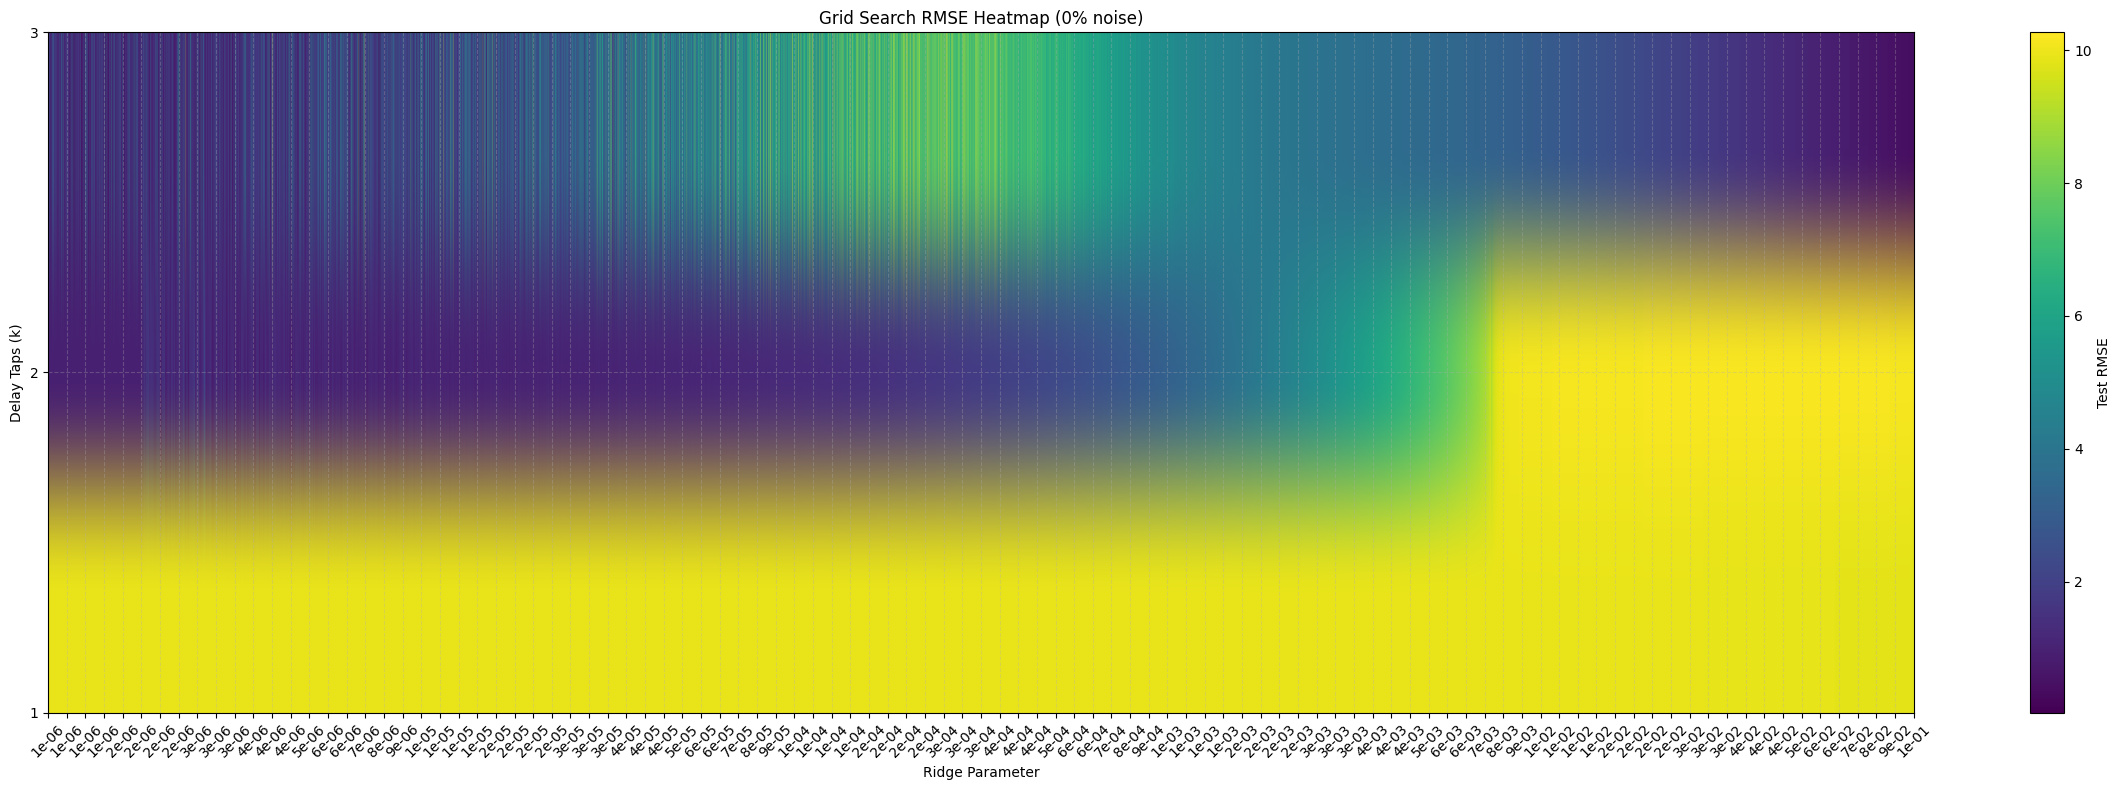

In [5]:
# ---------------------- Heatmap Phase 1 ----------------------
k_list = sorted(set(k for k, _, _ in results))
ridge_list = sorted(set(r for _, r, _ in results))
rmse_matrix = np.zeros((len(k_list), len(ridge_list)))

for k, ridge, rmse in results:
    i = k_list.index(k)
    j = ridge_list.index(ridge)
    rmse_matrix[i, j] = rmse

rmse_matrix[rmse_matrix > 1e2] = np.nan
log_ridge_list = np.log(ridge_list)

plt.figure(figsize=(24, 8))
im = plt.imshow(rmse_matrix, aspect='auto', origin='lower',
                extent=[log_ridge_list[0], log_ridge_list[-1], k_list[0], k_list[-1]],
                cmap='viridis')
plt.colorbar(im, label='Test RMSE')
plt.xlabel('Ridge Parameter')
plt.ylabel('Delay Taps (k)')
plt.title('Grid Search RMSE Heatmap (0% noise)')
plt.xticks(
    log_ridge_list[::100],
    [f"{v:.0e}" for v in ridge_list][::100],
    rotation=45
)
plt.yticks(k_list)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("grid_search_rmse_heatmap_0percent_1(95_5_split).png", dpi=600)
plt.show()